In [1]:
import pickle
from scipy import sparse
from tensorflow import keras
from tensorflow.keras import layers, models
import numpy as np
import spektral
import os
import tensorflow as tf
import pandas
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import keras_tuner as kt
from scipy.optimize import curve_fit
from scipy.interpolate import make_interp_spline, BSpline
import pandas as pd
import openpyxl

In [390]:
#counter current
cocurrent = pd.read_excel(r"C:\Users\buing\Documents\CBE 424\heat exchanger\cocurrent.xlsx")

In [391]:
print(cocurrent)

      ms     ts  Ms (kg/s)  mi1 (kg)  ti1 (s)  Mi1 (kg/s)  mi2 (kg)  ti2 (s)  \
0   8.09  10.15   0.797044      0.47    30.06    0.015635       NaN      NaN   
1   8.09  10.15   0.797044      1.01    15.08    0.066976       NaN      NaN   
2   8.09  10.15   0.797044      2.12    15.14    0.140026       NaN      NaN   
3   8.09  10.15   0.797044      2.16    10.20    0.211765       NaN      NaN   
4   8.09  10.15   0.797044      3.51    10.05    0.349254       NaN      NaN   
5   8.09  10.15   0.797044      6.14    10.04    0.611554      6.18    10.12   
6   7.38  10.15   0.727094      0.42    20.04    0.020958       NaN      NaN   
7   7.38  10.15   0.727094      1.14    15.07    0.075647       NaN      NaN   
8   7.38  10.15   0.727094      1.24    10.14    0.122288       NaN      NaN   
9   7.38  10.15   0.727094      2.51    10.17    0.246804       NaN      NaN   
10  7.38  10.15   0.727094      4.12    10.09    0.408325       NaN      NaN   
11  7.38  10.15   0.727094      6.14    

In [393]:
dat = pd.DataFrame(cocurrent)

In [394]:
hot_rate = dat["Ms (kg/s)"]
cold_rate = dat["Mi1 (kg/s)"]
wc = cold_rate
wh = hot_rate
Th_in = dat["Th_in"]
Th_out = dat["Th_out"]
Tc_in = dat["Tc_in"]
Tc_out = dat["Tc_out"]

In [415]:
dT_co = ((Th_in - Tc_in) - (Th_out - Tc_out))/np.log(((Th_in - Tc_in)/(Th_out - Tc_out)))
Cp = 4.182 #kJ/kgC
Qc = wc*Cp*(Tc_out- Tc_in)      #Qc = wc*Cp_c*(Tc_out - Tc_in)
Qh = wh*Cp*(Th_out- Th_in)   #Qh = wh*Cp_h*(Th_out- Th_in)
Q = (abs(Qc) + abs(Qh))/2
A = 31*np.pi*7.875*0.21/(39.37*39.37)
U = Q/(A*dT_co)
Gi = wc/(np.pi*31*np.power((0.21/39.37),2)/4)
Gs = wh/(np.pi*31*np.power((0.25/39.37),2)/4)
#dT_co = ((Th_in - Tc_in) - (Th_out - Tc_out))/np.log(((Th_in - Tc_in)/(Th_out - Tc_out)))
flip_U = 1/U
print(U)

0     1.015478
1     1.972480
2     2.585787
3     2.995092
4     3.624900
5     4.538645
6     1.090230
7     1.886224
8     2.248063
9     2.941242
10    3.554662
11    4.300478
12    1.149981
13    1.936917
14    2.815452
15    3.734732
16    4.167375
17    4.890917
18    1.064253
19    1.961523
20    2.612332
21    3.228890
22    3.925879
23    4.776420
24    1.171319
25    1.563901
26    2.640169
27    3.210606
28    3.968600
29    4.753614
30    1.492144
31    2.233083
32    2.915345
33    3.455786
34    3.891690
35    4.483023
dtype: float64


In [396]:
error_dat = dat[dat["mi2 (kg)"].notna()]
#print(error_dat)
Ms_err = error_dat["Ms (kg/s)"].to_numpy()
M1 = error_dat["Mi1 (kg/s)"].to_numpy()
M2 = error_dat["mi2 (kg)"].to_numpy()/error_dat["ti2 (s)"].to_numpy()
#print(M1,M2)
Avg_Mi = (M1+M2)/2
std_Mi = np.std([M1, M2],axis = 0)
print(Avg_Mi, std_Mi)

[0.61111286 0.61111286 0.01620378 0.08033048 0.01620378 0.51014855
 0.78762922 0.45319786 0.78762922] [0.00044092 0.00044092 0.00079622 0.00030402 0.00079622 0.00277392
 0.00262922 0.00215928 0.00262922]


In [416]:
print(error_dat)
Th_in_err = error_dat["Th_in"]
Th_out_err = error_dat["Th_out"]
Tc_in_err = error_dat["Tc_in"]
Tc_out_err = error_dat["Tc_out"]
Ms_err = error_dat["Ms (kg/s)"]
Gi_err = M1/(np.pi*31*np.power((0.21/39.37),2)/4)
Cp = 4.182
dT_counter_err = ((Th_in_err - Tc_in_err) - (Th_out_err - Tc_out_err))/np.log(((Th_in_err - Tc_in_err)/(Th_out_err - Tc_out_err)))
Qc_err1 = M1*Cp*(Tc_out_err - Tc_in_err)
Qc_err2 = M2*Cp*(Tc_out_err - Tc_in_err)
Qc_avg = (Qc_err1+Qc_err2)/2
Qc_std = np.std([Qc_err1, Qc_err2],axis = 0)
Qh = Ms_err*Cp*(Th_out_err - Th_in_err)
A = 31*np.pi*7.875*0.21/(39.37*39.37)
Q_err1 = (abs(Qc_err1) + abs(Qh))/2
Q_err2 = (abs(Qc_err2) + abs(Qh))/2
U_err1 = Q_err1/(A*dT_counter_err)
U_err2 = Q_err2/(A*dT_counter_err)
U_avg = (U_err1+U_err2)/2
U_std = np.std([U_err1, U_err2],axis = 0)
print(U_avg,U_std)

      ms     ts  Ms (kg/s)  mi1 (kg)  ti1 (s)  Mi1 (kg/s)  mi2 (kg)  ti2 (s)  \
5   8.09  10.15   0.797044      6.14    10.04    0.611554      6.18    10.12   
11  7.38  10.15   0.727094      6.14    10.04    0.611554      6.18    10.12   
18  6.11  10.18   0.600196      0.34    20.00    0.017000      0.31    20.12   
19  6.11  10.18   0.600196      1.22    15.13    0.080635      1.21    15.12   
24  5.66  10.50   0.539048      0.34    20.00    0.017000      0.31    20.12   
28  5.66  10.50   0.539048      5.16    10.17    0.507375      5.16    10.06   
29  5.66  10.50   0.539048      7.95    10.06    0.790258      7.85    10.00   
33  6.18  15.15   0.407921      4.56    10.11    0.451039      4.59    10.08   
35  6.18  15.15   0.407921      7.95    10.06    0.790258      7.85    10.00   

    Th_in  Th_out  Tc_in  Tc_out  
5   60.88   55.41  22.53   15.17  
11  59.58   53.94  22.10   15.55  
18  56.05   55.20  47.79   15.43  
19  55.27   52.92  33.11   15.28  
24  59.69   58.65  52.21

In [410]:
def func(G,a,b,c,d,e):
    Gi,Gs = G
    return (a/np.power(Gi,b)) + c + (d/np.power(Gs,e))
    #Sieder_tate_LHS = h*D/k
    #Sieder_tate_RHS = 0.023 * (D*G/miu)^0.8 * (Cp*miu/k)^(1/3) * (miu_b/miu_o)^0.14

    #Kern_LHS = h_o*D_e/k
    #Kern_RHS = 0.36 * (D_e*G_s/miu)^0.55 * (Cp*miu/k)^(1/3) * (miu_b/miu_o)^0.14

    #param fitting
    #LHS = 1/U
    #RHS = a/(wc^b) + c + d/(wh^e)

    #hi_exp = 1/a*wc^b
    #h0_exp = (1/d)*(Ai/A0)*(wh^e)


In [411]:
guess = [1, 0.3, 0, 1,0.6]
a,b,c,d,e = guess
LHS = func((Gi,Gs),a,b,c,d,e)
param = curve_fit(func,(Gi,Gs),flip_U,guess,maxfev=20000)
LHS_fit = func((Gi,Gs),*param[0])
U_fit = 1/LHS_fit

print(param)

(array([3.17037315e+00, 3.87033535e-01, 8.60557757e-03, 2.22625706e+01,
       4.74376033e+00]), array([[inf, inf, inf, inf, inf],
       [inf, inf, inf, inf, inf],
       [inf, inf, inf, inf, inf],
       [inf, inf, inf, inf, inf],
       [inf, inf, inf, inf, inf]]))


C:\Users\buing\anaconda3\envs\myenv\lib\site-packages\scipy\optimize\minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


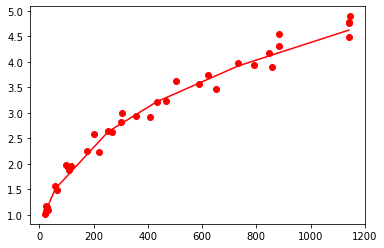

In [412]:

plt.plot(Gi,U,'ro')
Gi1 = Gi[0:6]
Gi2 = Gi[6:12]
Gi3 = Gi[12:18]
Gi4 = Gi[18:24]
Gi5 = Gi[24:30]
Gi6 = Gi[30:36]
Gs1 = Gs[0:6]
Gs2 = Gs[6:12]
Gs3 = Gs[12:18]
Gs4 = Gs[18:24]
Gs5 = Gs[24:30]
Gs6 = Gs[30:36]
U1 = U[0:6]
U2 = U[6:12]
U3 = U[12:18]
U4 = U[18:24]
U5 = U[24:30]
U6 = U[30:36]
Gs_1_fit = 1/(func((Gi[0:6],Gs[0:6]),*param[0]))
Gs_2_fit = 1/(func((Gi[6:12],Gs[6:12]),*param[0]))
Gs_3_fit = 1/(func((Gi[12:18],Gs[12:18]),*param[0]))
Gs_4_fit = 1/(func((Gi[18:24],Gs[18:24]),*param[0]))
Gs_5_fit = 1/(func((Gi[24:30],Gs[24:30]),*param[0]))
Gs_6_fit = 1/(func((Gi[30:36],Gs[30:36]),*param[0]))
#plt.plot(Gi[0:6],Gs_1_fit,'r-')
#plt.plot(Gi[6:12],Gs_2_fit,'r-')
#plt.plot(Gi[12:18],Gs_3_fit,'r-')
#plt.plot(Gi[18:24],Gs_4_fit,'r-')
plt.plot(Gi[24:30],Gs_5_fit,'r-')

[ 882.82642325  882.82642325   24.54084917  116.40230159   24.54084917
  732.43554706 1140.80078893  651.1099798  1140.80078893] 5     4.538645
11    4.300478
18    1.064253
19    1.961523
24    1.171319
28    3.968600
29    4.753614
33    3.455786
35    4.483023
dtype: float64


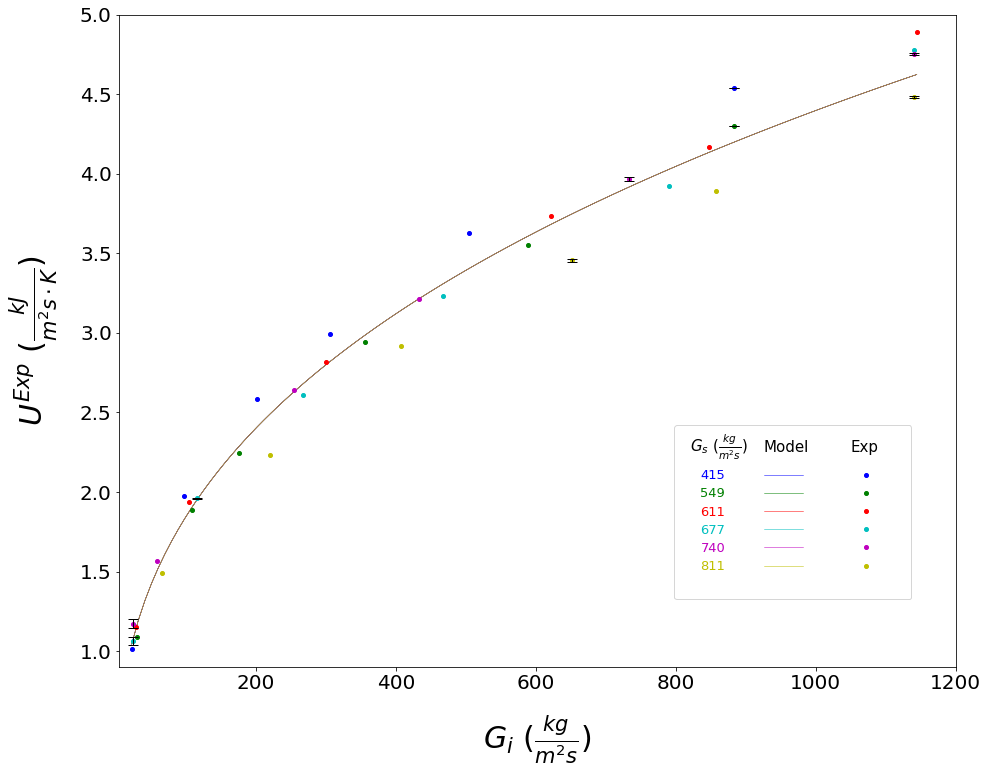

In [425]:
Gi_spline_1 = np.sort(Gi1)
Gi_spline_2 = np.sort(Gi2)
Gi_spline_3 = np.sort(Gi3)
Gi_spline_4 = np.sort(Gi4)
Gi_spline_5 = np.sort(Gi5)
Gi_spline_6 = np.sort(Gi6)

#U_spline_1 = 1/func((Gi_spline_1,Gs1),*param[0])
#U_spline_2 = 1/func((Gi_spline_1,Gs2),*param[0])
#U_spline_3 = 1/func((Gi_spline_1,Gs3),*param[0])
#U_spline_4 = 1/func((Gi_spline_1,Gs4),*param[0])
#U_spline_5 = 1/func((Gi_spline_1,Gs5),*param[0])
#U_spline_6 = 1/func((Gi_spline_1,Gs6),*param[0])
#D_model = np.linspace(D_spline.min(), D_spline.max(), 500)
Gi_model = np.linspace(Gi.min(),Gi.max(),120)
Gi_model1 = np.linspace(Gi1.min(), Gi1.max(), 120)
Gi_model2 = np.linspace(Gi2.min(), Gi2.max(), 120)
Gi_model3 = np.linspace(Gi3.min(), Gi3.max(), 120)
Gi_model4 = np.linspace(Gi4.min(), Gi4.max(), 120)
Gi_model5 = np.linspace(Gi5.min(), Gi5.max(), 120)
Gi_model6 = np.linspace(Gi6.min(), Gi6.max(), 120)
#Gi1_spl = make_interp_spline(Gi_spline_1,U_spline_1)
#Gi2_spl = make_interp_spline(Gi_spline_2,U_spline_2)
#Gi3_spl = make_interp_spline(Gi_spline_3,U_spline_3)
#Gi4_spl = make_interp_spline(Gi_spline_4,U_spline_4)
#Gi5_spl = make_interp_spline(Gi_spline_5,U_spline_5)
#Gi6_spl = make_interp_spline(Gi_spline_6,U_spline_6)
Gs_model1 = np.repeat(Gs1,20)
Gs_model2 = np.repeat(Gs2,20)
Gs_model3 = np.repeat(Gs3,20)
Gs_model4 = np.repeat(Gs4,20)
Gs_model5 = np.repeat(Gs5,20)
Gs_model6 = np.repeat(Gs6,20)
U1_model =  1/func((Gi_model,Gs_model1),*param[0])
U2_model = 1/func((Gi_model,Gs_model2),*param[0])
U3_model = 1/func((Gi_model,Gs_model3),*param[0])
U4_model = 1/func((Gi_model,Gs_model4),*param[0])
U5_model = 1/func((Gi_model,Gs_model5),*param[0])
U6_model = 1/func((Gi_model,Gs_model6),*param[0])
label = np.unique(Gs)
l_width = 0.5
marksize = 4
fig = figure(figsize = (15,12))
plt.plot(Gi_model,U1_model,'b-',linewidth = l_width, label = str(int(label[0])))
#plt.annotate(int(label[0]),
#             xy = (   Gi_model[-1],(U1_model.to_numpy())[-1]),
#             xytext= (  1.01*Gi_model[-1],1.01*(U1_model.to_numpy())[-1]),
#             color = 'b'
#            )

plt.plot(Gi_model,U2_model,'g-',linewidth = l_width, label = str(int(label[1])))
#plt.annotate(int(label[1]),
#             xy = (   Gi_model[-1],(U2_model.to_numpy())[-1]),
#             xytext= (   1.01*Gi_model[-1],1.0*(U2_model.to_numpy())[-1]),
#             color = 'g'
#            )

plt.plot(Gi_model,U3_model,'r-',linewidth = l_width, label = str(int(label[2])))
#plt.annotate(int(label[2]),
#             xy = (   Gi_model[-1],(U3_model.to_numpy())[-1]),
#             xytext= (   1.01*Gi_model[-1],1.0*(U3_model.to_numpy())[-1]),
#             color = 'r'
#            )
plt.plot(Gi_model,U4_model,'c-',linewidth = l_width, label = str(int(label[3])))
#plt.annotate(int(label[3]),
#             xy = (   Gi_model[-1],(U4_model.to_numpy())[-1]),
#             xytext= (   1.01*Gi_model[-1],1.0*(U4_model.to_numpy())[-1]),
#             color = 'c'
#            )
plt.plot(Gi_model,U5_model,'m-',linewidth = l_width, label = str(int(label[4])))
#plt.annotate(int(label[4]),
#             xy = (   Gi_model[-1],(U5_model.to_numpy())[-1]),
#             xytext= (   1.01*Gi_model[-1],1.0*(U5_model.to_numpy())[-1]),
#             color = 'm'
#            )
plt.plot(Gi_model,U6_model,'y-',linewidth = l_width, label = str(int(label[5])))
#plt.annotate(int(label[5]),
#             xy = (   Gi_model[-1],(U6_model.to_numpy())[-1]),
#             xytext= (   1.01*Gi_model[-1],1.0*(U6_model.to_numpy())[-1]),
#             color = 'y'
#            )
plt.plot(Gi1,U1,'bo',markersize = marksize, label = " ")#str(int(label[0])))
plt.plot(Gi2,U2,'go',markersize = marksize, label = " ")#str(int(label[1])))
plt.plot(Gi3,U3,'ro',markersize = marksize, label = " ")#str(int(label[2])))
plt.plot(Gi4,U4,'co',markersize = marksize, label = " ")#str(int(label[3])))
plt.plot(Gi5,U5,'mo',markersize = marksize, label = " ")#str(int(label[4])))
plt.plot(Gi6,U6,'yo',markersize = marksize, label = " ")#str(int(label[5])))


plt.text(820,2.25,r"$G_s$ $(\frac{kg} {m^{2}s})$",
             #xy = (   Gi_model[-1],(U5_model.to_numpy())[-1]),
             #xytext= (0.59*Gi_model[-1],0.55*(U5_model.to_numpy())[-1]),
            fontsize = 15, zorder = 100
            )

plt.text(925,2.25, 'Model', fontsize = 15, zorder =100)
plt.text(1050,2.25, 'Exp', fontsize = 15, zorder =100)
#plt.text.pop()
legend = plt.legend(ncol = 2, loc = 'lower right', fontsize = 13, title = " ",markerfirst = False,labelcolor =('b','g','r','c','m','y'),labelspacing = 0.4
                   ,handlelength =3,handletextpad = 3,columnspacing = 0,bbox_to_anchor = (0.95,0.1),frameon = True,borderpad = 2,borderaxespad = 0.2) #^{Exp}
legend.get_title().set_fontsize('13')
legend.get_title().set_ha('left')
plt.ylim(0.9,5)
plt.xlim(4,1200)
plt.ylabel(r"$U^{Exp}$ $(\frac{kJ} {m^{2}s \cdot{K}})$", fontsize = 30,labelpad=20)
plt.xlabel(r"$G_i$ $(\frac{kg} {m^{2}s})$",fontsize = 30,labelpad=20)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.errorbar(Gi_err,U_err1,yerr = [U_std], fmt = 'none',ecolor = 'black',capsize = 5,elinewidth = 1)
#spl = make_interp_spline(D_spline,phin_model_point)
#color = cm.rainbow(np.linspace(0, 1, n))
#for i, c in zip(range(n), color):
#   plt.plot(x, y, c=c)
print(Gi_err,U_err1)

In [ ]:
print(Gi_model[-1])
print( str(int(label[0])) + " exp")

In [ ]:
print(Gi_spline_1,Gi[0:6])

In [ ]:
print(Gi_spline_1)